<div class="alert alert-block alert-success">
    <b><center>Sequential & Functional API Model</center></b>
    <b><center>Based On TensorFlow Documents</center></b>
</div>

# Configure Learning Environment

In [1]:
# !pip install git+https://github.com/nockchun/rspy --force
# !pip install mybatis_mapper2sql
import rspy as rsp
rsp.setSystemWarning(off=True)
rsp.fixMemoryProblem()

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models, utils

In [3]:
np.set_printoptions(linewidth=200, precision=2)
tf.__version__

'2.2.0'

# Neuron by Dense
Generally, all layers in Keras need to know the shape of their inputs in order to be able to create their weights. So when you create a layer like this, initially, it has no weights:

In [4]:
layer = layers.Dense(3)
layer.weights  # Empty

[]

It creates its weights the first time it is called on an input, since the shape of the weights depends on the shape of the inputs:

In [5]:
# Call layer on a test input
x = tf.ones((1, 4))
y = layer(x)
layer.weights  # Now it has weights, of shape (4, 3) and (3,)

[<tf.Variable 'dense/kernel:0' shape=(4, 3) dtype=float32, numpy=
 array([[-0.14,  0.3 ,  0.34],
        [-0.22, -0.22,  0.6 ],
        [ 0.08, -0.19,  0.3 ],
        [-0.71, -0.62, -0.61]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

# Creating a Sequential model
You can create a Sequential model by passing a list of layers to the Sequential constructor:

Also note that the Sequential constructor accepts a name argument, just like any layer or model in Keras. This is useful to annotate TensorBoard graphs with semantically meaningful names.

In [6]:
model = tf.keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="dense_01"),
        layers.Dense(3, activation="relu", name="dense_02"),
        layers.Dense(4, name="output"),
    ], name="seq_model"
)

It's layers are accessible via the layers attribute:

In [7]:
for item in model.layers:
    print(item.name)

dense_01
dense_02
output


You can also create a Sequential model incrementally via the add() method:

In [8]:
model = tf.keras.Sequential()
model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(3, activation="relu"))
model.add(layers.Dense(4))

Note that there's also a corresponding pop() method to remove layers: a Sequential model behaves very much like a list of layers.

In [9]:
model.pop()
model.layers

Schematically, the above Sequential model is equivalent to this function:

In [10]:
# Create 3 layers
layer1 = layers.Dense(2, activation="relu", name="layer1")
layer2 = layers.Dense(3, activation="relu", name="layer2")
layer3 = layers.Dense(4, name="layer3")

# Call layers on a test input
x = tf.ones((3, 3))
y = layer3(layer2(layer1(x)))

Naturally, weights of dense also applies to Sequential models. When you instantiate a Sequential model without an input shape, it isn't "built": it has no weights (and calling model.weights results in an error stating just this). The weights are created when the model first sees some input data:

In [11]:
model = tf.keras.Sequential(
    [
        layers.Dense(2, activation="relu"),
        layers.Dense(3, activation="relu"),
        layers.Dense(4),
    ]
)  # No weights at this stage!

In [12]:
# At this point, you can't do this:
# model.weights

In [13]:
# You also can't do this:
# model.summary()

In [14]:
# Call the model on a test input
x = tf.ones((1, 4))
y = model(x)
print("Number of weights after calling the model:", len(model.weights))  # 6

Number of weights after calling the model: 6


In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  10        
_________________________________________________________________
dense_5 (Dense)              multiple                  9         
_________________________________________________________________
dense_6 (Dense)              multiple                  16        
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


18*18

# Input
you should start your model by passing an Input object to your model, so that it knows its input shape from the start:

In [16]:
model = tf.keras.Sequential()
model.add(layers.Input(shape=(4,)))
model.add(layers.Dense(2, activation="relu"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 2)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


Note that the Input object is not displayed as part of model.layers, since it isn't a layer:

In [17]:
model.layers

In [18]:
# A simple alternative is to just pass an input_shape argument to your first layer:
model = tf.keras.Sequential()
model.add(layers.Dense(2, activation="relu", input_shape=(4,)))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [19]:
model = tf.keras.Sequential()
model.add(layers.Dense(2, input_shape=(4,)))
model.add(layers.Activation("relu"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 2)                 10        
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.layers

# debugging workflow
When building a new Sequential architecture, it's useful to incrementally stack layers with add() and frequently print model summaries. For instance, this enables you to monitor how a stack of Conv2D and MaxPooling2D layers is downsampling image feature maps:

In [21]:
model = tf.keras.Sequential()
model.add(layers.Input(shape=(250, 250, 3)))  # 250x250 RGB images
model.add(layers.Conv2D(32, 5, strides=2, activation="relu"))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(3))

# Can you guess what the current output shape is at this point? Probably not.
# Let's just print it:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 123, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
Total params: 11,680
Trainable params: 11,680
Non-trainable params: 0
_________________________________________________________________


In [22]:
# The answer was: (40, 40, 32), so we can keep downsampling...
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(2))

# And now?
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 123, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 32)       

In [23]:
# Now that we have 4x4 feature maps, time to apply global max pooling.
model.add(layers.GlobalMaxPooling2D())

# Finally, we add a classification layer.
model.add(layers.Dense(10))

# And now?
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 123, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 32)       

# Functional API
The Keras functional API is a way to create models that are more flexible than the tf.keras.Sequential API. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build graphs of layers.

* Consider the following model:
><pre>
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: logits of a probability distribution over 10 classes)
</pre>

This is a basic graph with three layers. To build this model using the functional API, start by creating an input node:

In [24]:
inputs = tf.keras.Input(shape=(784,))

In [25]:
# The inputs that is returned contains information about the shape and dtype of the input data that you feed to your model.
# Here's the shape:
inputs.shape, inputs.dtype

(TensorShape([None, 784]), tf.float32)

In [26]:
# If, for example, you have an image input with a shape of (32, 32, 3), you would use:
img_inputs = tf.keras.Input(shape=(32, 32, 3))

You create a new node in the graph of layers by calling a layer on this inputs object:

In [27]:
dense = layers.Dense(64, activation="relu")
x = dense(inputs)

The "layer call" action is like drawing an arrow from "inputs" to this layer you created. You're "passing" the inputs to the dense layer, and you get x as the output.

In [28]:
# Let's add a few more layers to the graph of layers:
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

At this point, you can create a Model by specifying its inputs and outputs in the graph of layers:

In [29]:
model = models.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


You can also plot the model as a graph:

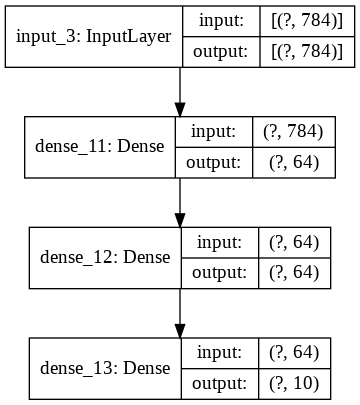

In [30]:
utils.plot_model(model, "intermediate/model.png", True)

This figure and the code are almost identical. In the code version, the connection arrows are replaced by the call operation.

A "graph of layers" is an intuitive mental image for a deep learning model, and the functional API is a way to create models that closely mirrors this.